In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from load_compression_models import my_bmshj2018_factorized
from sklearn.metrics.pairwise import cosine_similarity

def display_pil_img(img):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def display_tensor_img(img):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    plt.show()

def extract_features(model, dataloader, num_batches=100):
    features_list = []
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i == num_batches:
                break
            features = model(images)
            features_list.append(features['y_hat'])
    return torch.cat(features_list, dim=0)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load the CelebA dataset
dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    'mps'
net = my_bmshj2018_factorized(quality=2, pretrained=True).eval().to(device)
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

features = extract_features(net, dataloader)

# Compute similarities
features_np = features.view(features.size(0), -1).numpy()
similarities = cosine_similarity(features_np)

# Find most similar pairs
num_images = similarities.shape[0]
np.fill_diagonal(similarities, 0)  # Ignore self-similarity
most_similar = np.unravel_index(np.argmax(similarities, axis=None), similarities.shape)

# Print the most similar pairs
print(f"Most similar images indices are {most_similar[0]} and {most_similar[1]}")

Files already downloaded and verified
Parameters: 2998147
Most similar images indices are 351 and 3183


In [2]:
img_1, img_2 = dataset[most_similar[0]][0], dataset[most_similar[1]][0]

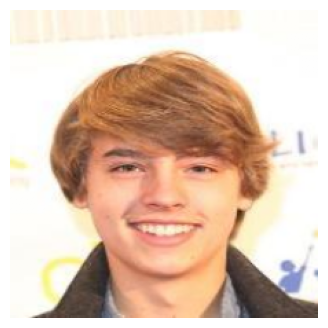

In [5]:
display_tensor_img(img_1)

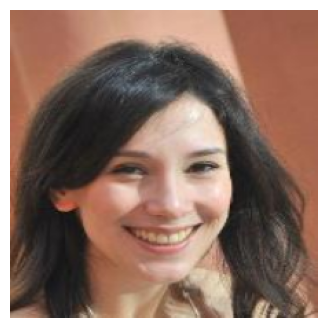

In [6]:
display_tensor_img(img_2)